# Skynet - interview case

# 1) Region finder with multi-processing 

* You are given the location of a home at Latitude 45.55 and Longitude -80.22,  find the closest RegionID

* For that RegionID determine the Average Loss over a 100,000 year period.  You can also then calculate the TVAR(80) also assuming a 100,000 year period.  Note:  the number of RegionID here is a very small sample of locations that exist in Canada. What you are seeing here is a small fraction of all RegionID we will need to consider.  You therefore need to build your query using some sort of multi processing approach to minimize run time.  For the full set of data we have reduced this to less than a second.

* Find the 5 nearest neighbours to that RegionID, with the same Characteristics, and plot the Mean Loss for each of the nearest neighbours so you can visualize a heat map. Plot the heat map on top of a high resolution satellite image of the area.


#### Imports

In [1]:
import multiprocessing
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import geopy.distance as gpy_dist

%matplotlib inline

#### Data Analysis/Visualization - regionID_and_Characteristics.csv

In [2]:
#Load data. Rename missing column name.
dfc = pd.read_csv('./data/regionID_and_Characteristics.csv', header=0)
dfc.rename(columns={'Unnamed: 0': 'Tag'}, inplace=True)
dfc.head()

,Tag,RegionID,Latitude,Longitude,FSA,Characteristic_1,Characteristic_2,Characteristic_3,Stories
0,451897,189734,44.170834,-78.787498,L0B,2,11,21,0
1,451898,189735,44.187500,-78.787498,L0B,2,11,21,0
2,451929,189766,43.837502,-79.145836,L1X,2,11,21,0
3,451930,189767,43.837502,-79.137497,L1X,2,11,21,0
4,452090,189927,45.887501,-80.720833,P0G,2,11,21,0


In [3]:
#Inspect NaN.
dfc.isna().sum()

Tag                 0
RegionID            0
Latitude            0
Longitude           0
FSA                 0
Characteristic_1    0
Characteristic_2    0
Characteristic_3    0
Stories             0
dtype: int64

In [4]:
dfc.describe()

,Tag,RegionID,Latitude,Longitude,Characteristic_1,Characteristic_2,Characteristic_3,Stories
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.0
mean,452128.540000,189965.540000,45.571917,-80.337583,1.990000,11.990000,22.000000,0.0
std,51.973268,51.973268,0.373542,0.308008,0.822598,0.822598,0.852803,0.0
min,451897.000000,189734.000000,43.837502,-80.720833,1.000000,11.000000,21.000000,0.0
25%,452110.750000,189947.750000,45.437500,-80.504166,1.000000,11.000000,21.000000,0.0
50%,452135.500000,189972.500000,45.604168,-80.370834,2.000000,12.000000,22.000000,0.0
75%,452160.250000,189997.250000,45.770832,-80.279167,3.000000,13.000000,23.000000,0.0
max,452185.000000,190022.000000,45.995834,-78.787498,3.000000,13.000000,23.000000,0.0


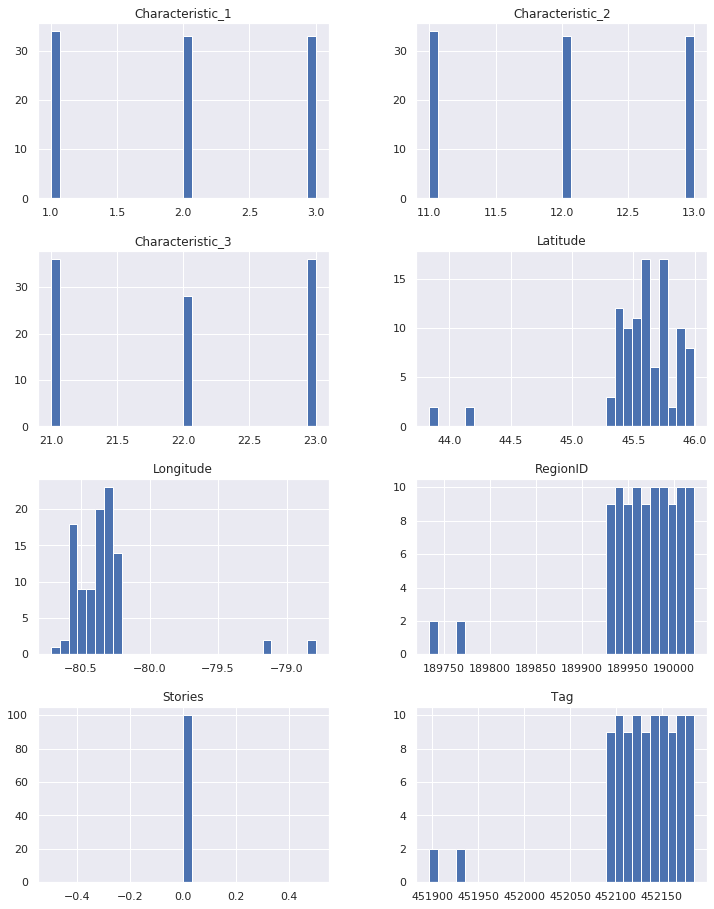

In [5]:
#Show the histogram of all numeric variables. Inspect for outliers and meaningless features.
sns.set(font_scale=1.)
hist = dfc.hist(bins=30, figsize=(12,20), layout=(5,2))

In [6]:
#Let's drop the Stories and Tag columns, as they do not contain relevant information in this dataset.
#Use try/except in case we attempt to drop more than once. 
try:
    dfc.drop(['Stories', 'Tag'], axis=1, inplace=True)
except:
    pass

#### Data Analysis/Visualization - regionID_and_event_losses.csv

In [7]:
dfe = pd.read_csv('./data/regionID_and_event_losses.csv', header=0)
dfe.rename(columns={'Unnamed: 0': 'Index'}, inplace=True)
dfe.head()

,Index,RegionID,EventID,YearID,GroundUpLoss
0,0,189734,5758.0,39222,1.185160
1,1,189735,5758.0,39222,1.187346
2,2,189734,5758.0,39223,3.580194
3,3,189735,5758.0,39223,3.582398
4,4,189766,5758.0,39223,1.214846


In [8]:
dfe.isna().sum()

Index           0
RegionID        0
EventID         0
YearID          0
GroundUpLoss    0
dtype: int64

In [9]:
dfe.describe()

,Index,RegionID,EventID,YearID,GroundUpLoss
count,993033.000000,993033.000000,993033.000000,993033.000000,993033.000000
mean,496516.000000,189966.231672,5034.256885,34244.964928,16.896187
std,286664.079268,55.844566,2881.747929,19673.435834,314.658409
min,0.000000,189734.000000,1.000000,1.000000,0.507096
25%,248258.000000,189951.000000,2518.000000,17165.000000,1.182945
50%,496516.000000,189976.000000,5037.000000,34193.000000,1.203849
75%,744774.000000,189999.000000,7538.000000,51243.000000,2.408984
max,993032.000000,190022.000000,10000.000000,68142.000000,26599.409160


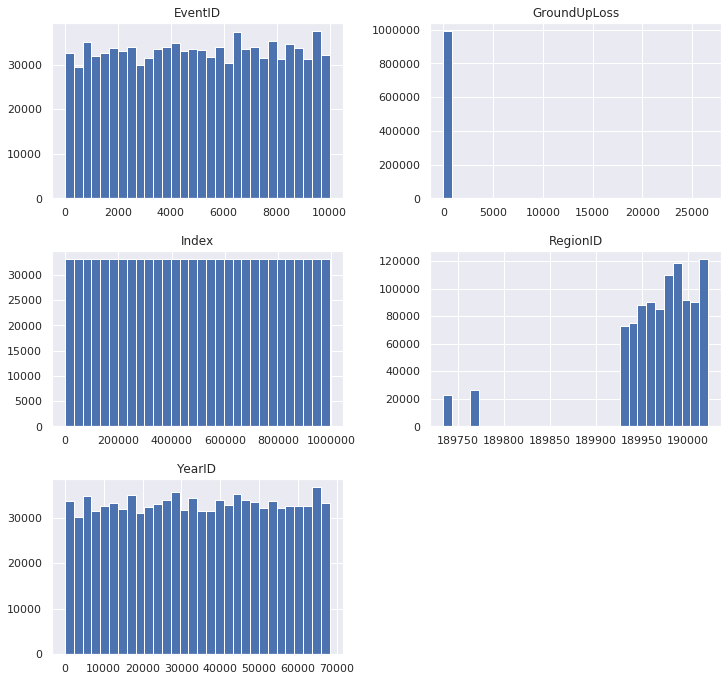

In [10]:
#Show the histogram of all numeric variables. Inspect for outliers and meaningless features.
sns.set(font_scale=1.)
hist = dfe.hist(bins=30, figsize=(12,20), layout=(5,2))

#### Locate RegionID

In [11]:
#Set target values.
target_lat = 45.55
target_long = -80.22

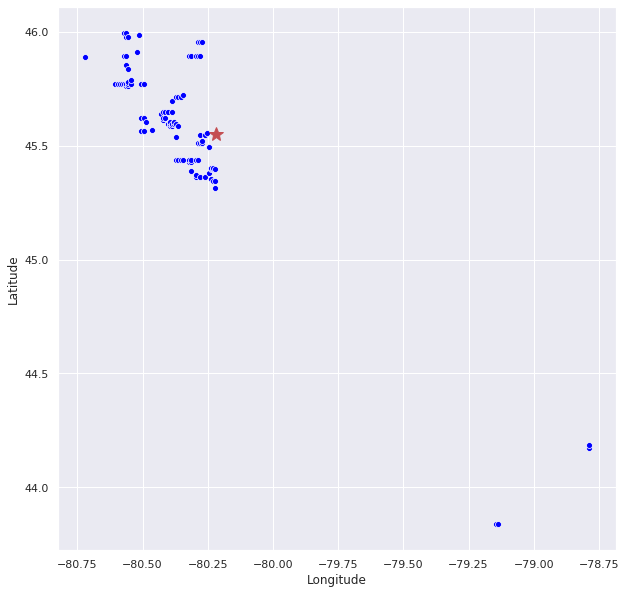

In [12]:
#First, visualize the distribution of coordinates.
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x='Longitude', y='Latitude', data=dfc, color='blue', ax=ax)
ax.plot([target_long], [target_lat], ls='None', color='r', marker='*', markersize=15.)

#### -- Solution 1.1 - Closest regionID --

In [16]:
def closest_RegionID(_target_lat,_target_long, _df):
    """Given a target location, find the nearest RegionID.
    Calculate distances using geopy, which provides a good approximation
    for Earth's shape.
    
    Resource: https://stackoverflow.com/questions/40357434/pandas-df-iterrows-parallelization
    """
    
    #Set tuple with target latitude and longitude.
    target = (target_lat,target_long)

    #Compute distances relative to target. 
    dist = np.array([gpy_dist.distance((lat,long), target).km
                     for lat, long in zip(_df['Latitude'].values, _df['Longitude'].values)])

    #Get location in dataframe that corresponds to the minimum distance.
    mindist_idx = dist.argmin()

    #Retrieve Region ID for that distance.
    closest_regionID = _df['RegionID'].iloc[mindist_idx]
    
    return closest_regionID

%timeit sol_regionID = closest_RegionID(target_lat, target_long, dfc)
print('RegionID of closest point to target latitude and longitude: %d' %sol_regionID)


32.8 ms ± 1.41 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
RegionID of closest point to target latitude and longitude: 190011


#### Solution 1.1 -- speedup

In [24]:
def compute_distance(lat, long):   
    #Set tuple with target latitude and longitude.
    target = (target_lat,target_long)
    return gpy_dist.distance((lat, long), target).km

def closest_RegionID(_df, num_proc):
    """Given a target location, find the nearest RegionID.
    Calculate distances using geopy, which provides a good approximation
    for Earth's shape.
    """
    
    #Create a list of tuples containing latitudes and longitudes.
    lat_long = zip(_df['Latitude'].values, _df['Longitude'].values)
    
    #Compute distances relative to target. 
    with multiprocessing.Pool(processes=num_proc) as pool:
        distances = np.asarray(pool.starmap(compute_distance, lat_long))

    #Get location in dataframe that corresponds to the minimum distance.
    mindist_idx = distances.argmin()

    #Retrieve Region ID for that distance.
    closest_regionID = _df['RegionID'].iloc[mindist_idx]
    
    return closest_regionID

#Define how many cpu's to use. First option will assign as many as available.
#num_processes = multiprocessing.cpu_count()
num_processes = 8

%timeit sol_regionID = closest_RegionID(dfc, num_processes)
print('RegionID of closest point to target latitude and longitude: %d' %sol_regionID)

180 ms ± 846 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
RegionID of closest point to target latitude and longitude: 190011


#### -- Solution 1.2 - Average Loss --

In [ ]:
#Define function to compute average loss.
def get_averageLoss(regionID, _df):
        
    #Trim dataframe to include only that regionID.
    df_aux = _df[_df['RegionID'] == regionID]
    
    #We do not know the relationship between YearID and actual time. The average should be time weighted.
    #The problem states that we can ASSUME 100,000 yr period. Hence, I will assume YearID to be equally spaced.
    loss_avg = np.mean(df_aux['GroundUpLoss'].values)

    return loss_avg

avg_loss = get_averageLoss(sol_regionID, dfe)
print('The average ground loss for RegionID %d is %.4f' %(sol_regionID, avg_loss)) 

#### -- Solution 1.3 - 5 Nearest Neighbors --

In [ ]:
def find_neighbors(regionID, _dfc, _dfe):
    
    #Retrieve characterics of the target RegionID.
    df_aux = _dfc[_dfc['RegionID'] == regionID]
    lat = df_aux['Latitude'].values[0]
    long = df_aux['Longitude'].values[0]
    char1 = df_aux['Characteristic_1'].values[0]
    char2 = df_aux['Characteristic_2'].values[0]
    char3 = df_aux['Characteristic_3'].values[0]

    #Find subset of RegionIDs that share the same characteristics.
    df_aux = _dfc[((_dfc['Characteristic_1'] == char1)
                  & (_dfc['Characteristic_2'] == char2)
                  & (_dfc['Characteristic_3'] == char3)
                  )]
    
    #Find five closest neighbors. First, remove target from dataframe to prevent a distance of zero.
    df_aux = df_aux[df_aux.RegionID != regionID]
    
    neighbor_RegionID = []
    for i in range(5):
        rID = closest_RegionID(lat,long, df_aux, 8)
        #Drop the retrieved regionID to prevent repetition.
        df_aux = df_aux[df_aux.RegionID != rID]
        neighbor_RegionID.append(rID)
    
    #For each of the five nearest neighbors, compute the average GroundUpLoss.
    mean_loss = [get_averageLoss(rID, _dfe) for rID in neighbor_RegionID]
    
    return list(zip(neighbor_RegionID,mean_loss)), lat, long
    
results, lat, long = find_neighbors(sol_regionID, dfc, dfe)
results

In [ ]:
#Sanity check
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x='Longitude', y='Latitude', data=dfc, color='blue', ax=ax)
ax.plot([target_long], [target_lat], ls='None', color='r', marker='*', markersize=15.)

for rID in np.transpose(results)[0]:
    lat, long = dfc[dfc['RegionID'] == rID][['Latitude', 'Longitude']].values[0]
    ax.plot([long], [lat], ls='None', color='g', marker='^', markersize=10.)
    


#### Playing with Satellite imagery

In [ ]:
import os
import requests
import json
from requests.auth import HTTPBasicAuth
from planet import api
os.environ['PL_API_KEY']='43d7e803fb304bcd85cf50aa9b242b6d'

client = api.ClientV1()

In [ ]:
geojson_geometry = {
  "type": "Polygon",
  "coordinates": [
          [
            [
              long - 0.1,
              lat - 0.1
            ],
            [
              long + 0.1,
              lat - 0.1
            ],
            [
              long + 0.1,
              lat + 0.1
            ],
            [
              long - 0.1,
              lat - 0.1
            ]
          ]
        ]
      }

In [ ]:
geojson_geometry = {
  "type": "Polygon",
  "coordinates": [
    [ 
      [438.2666015625,22.27893059841188],
      [440.013427734375,22.27893059841188],
      [440.013427734375,23.33216830631147],
      [438.2666015625,23.33216830631147],
      [438.2666015625,22.27893059841188]
    ]
  ]
}

In [ ]:
# get images that overlap with our AOI 
geometry_filter = {
  "type": "GeometryFilter",
  "field_name": "geometry",
  "config": geojson_geometry
}

# get images acquired within a date range
date_range_filter = {
  "type": "DateRangeFilter",
  "field_name": "acquired",
  "config": {
    "gte": "2016-08-31T00:00:00.000Z",
    "lte": "2016-09-01T00:00:00.000Z"
  }
}

# only get images which have <50% cloud coverage
cloud_cover_filter = {
  "type": "RangeFilter",
  "field_name": "cloud_cover",
  "config": {
    "lte": 0.5
  }
}

# combine our geo, date, cloud filters
combined_filter = {
  "type": "AndFilter",
  "config": [geometry_filter, date_range_filter, cloud_cover_filter]
}

In [ ]:
# API Key stored as an env variable
PLANET_API_KEY = os.getenv('PL_API_KEY') 

# will get a 4 band image with spectral data for Red, Green, Blue and Near-infrared values
item_type = "PSScene4Band"

# API request object
search_request = {
  "interval": "day",
  "item_types": [item_type], 
  "filter": combined_filter
}

# fire off the POST request
search_result = \
  requests.post(
    'https://api.planet.com/data/v1/quick-search',
    auth=HTTPBasicAuth(PLANET_API_KEY, ''),
    json=search_request)

print(json.dumps(search_result.json(), indent=1))

In [ ]:
# extract image IDs only
image_ids = [feature['id'] for feature in search_result.json()['features']]
print(image_ids)

# For demo purposes, just grab the first image ID
id0 = image_ids[0]
id0_url = 'https://api.planet.com/data/v1/item-types/{}/items/{}/assets'.format(item_type, id0)

# Returns JSON metadata for assets in this ID. Learn more: planet.com/docs/reference/data-api/items-assets/#asset
result = \
  requests.get(
    id0_url,
    auth=HTTPBasicAuth(PLANET_API_KEY, '')
  )

# List of asset types available for this particular satellite image
print(result.json().keys())

# This is "inactive" if the "analytic" asset has not yet been activated; otherwise 'active'
print(result.json()['analytic_dn']['status'])

In [ ]:
links = result.json()[u"analytic"]["_links"]
self_link = links["_self"]
activation_link = links["activate"]

# Request activation of the 'analytic' asset:
activate_result = \
  requests.get(
    activation_link,
    auth=HTTPBasicAuth(PLANET_API_KEY, '')
  )

In [ ]:
activation_status_result = \
requests.get(
  self_link,
  auth=HTTPBasicAuth(PLANET_API_KEY, '')
  )
    
print(activation_status_result.json()["status"])

In [ ]:
print(activation_status_result.json()["status"])

In [ ]:
download_link = activation_status_result.json()["location"]
print(download_link)

# 2) Natural Hazard Models

* In the insurance industry, there is always a challenge in blending actual claims results with modelled claim results, where the model can be purchased from a third party.  As one example,  there is a Winterstorm model that can be purchased from two different third party (AIR Worldwide or RMS).  We need to evaluate the model results versus actual results and blend.  How would you go about blending actual and modelled claims results?  Think about 2 or 3 ways you would do this:
  * Link to AIR Worldwide Winterstorm: https://www.air-worldwide.com/.../The-AIR-Winter-Storm-Model-for-Canada/
  * Link to RMS Winterstorm: https://www.rms.com/models/winter-storm

* One project coming up will be to re-write a publicly available piece of software called Prometheus.  Prometheus is a fire growth model which predicts the spread of a wildfire once there is an ignition in a forest.  How would you go about writing this in Python?   Keep in mind there is a lot of research papers / literature on how fire growth occurs.  So we are just using this as an example.  Recommendation: This is a long document and don’t spend your time reading the whole thing.  Maybe focus on wave vs cellular propagation and Rate of Spread as key things to consider when writing in Python. 
  * Link to Prometheus: http://www.firegrowthmodel.ca/prometheus/documentation_e.php


# 3) Data Science

* Stochastic Optimization / Stochastic Gradient Descent ---> in what settings have you had to use this approach for optimization of ML methods?  Give us an example.
* Different ML Approaches ---> What approaches have you used in the past?  Give us an example of a few that you have used and why they worked well.  What sort of visualizations did you use to determine which approach was the best.

# 4) Data Engineering / Software Engineering

* NoSQL / MongoDB / MapReduce ---> in what settings has he used these in the past
* Django / Front end --> does he have an interest in developing these pieces of the system